# ProLiFIC EDA Notebook

Welcome to the **Exploratory Data Analysis (EDA)** notebook for the **ProLiFIC** dataset — *Procedural Lawmaking Flow in Italian Chambers*. This notebook walks you through:

- Loading and inspecting the event log and metadata
- Parsing timestamps and cleaning key fields
- Merging metadata with procedural event data
- Converting the dataset into a format suitable for **process mining** with `pm4py`
- Computing descriptive statistics and case durations
- Exploring temporal patterns and institutional trends in legislative processes

The ProLiFIC dataset covers Italian parliamentary activity from **1987 to 2022**, capturing detailed procedural traces for each legislative case. It is particularly suited for research in:

- **Legal process mining**
- **Governance and institutional modeling**
- **Temporal and policy analysis**

This EDA lays the foundation for more advanced questions about lawmaking duration, decree-law usage, legislative bottlenecks, and institutional dynamics.

## 📦 Requirements

This notebook requires the following Python libraries:

- `pandas` – for data manipulation
- `numpy` – for numerical operations
- `matplotlib` – for basic visualizations
- `pm4py` – for process mining functionalities

To install the missing libraries, run:

```bash
pip install pandas numpy matplotlib pm4py

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter

## 📄 Load Data

We begin by loading the two main components of the ProLiFIC dataset:

- `ProLiFIC_event_log.csv`: procedural events (one row per event)
- `ProLiFIC_metadata.csv`: metadata per case (one row per law)

In [14]:
# Load event log and metadata
event_log = pd.read_csv('data/ProLiFIC_event_log.csv', index_col=False)
metadata = pd.read_csv('data/ProLiFIC_metadata.csv', index_col=False)

### Format Timestamps

We convert the `time` column to datetime format. The original format includes year, month, day, hour, and minute.

In [15]:
# Convert the 'time' column from string to datetime, matching the format YYYY‑MM‑DD‑HH‑MM
event_log['time'] = pd.to_datetime(
    event_log['time'], 
    format='%Y-%m-%d-%H-%M', 
    errors='coerce')

### Merge Metadata

We enrich the event log with metadata fields such as:
- `decree_conversion`: Whether the law is a conversion of a decree-law
- `legislature`: The legislative term

In [ ]:
# Choose columns to merge
cols = ['case_id', 'decree_conversion', 'legislature']

df = event_log.merge(
    metadata[cols], 
    on='case_id', 
    how='left'
)

# Optional: save the merged dataset for reuse
# df.to_csv('ProLiFIC_merged.csv', index=False)

## 📊 Dataset Overview

This overview uses the merged dataset, combining event log data with metadata. We report:

- The total number of unique legislative cases (`case_id`)
- The number of legislatures represented
- Counts of decree-law conversions
- The most common legislative activities (in English)

In [18]:
print("Dataset Overview (merged DataFrame)")

num_cases = df['case_id'].nunique()
num_legislatures = df['legislature'].nunique()
num_decrees = df['decree_conversion'].sum()
top_activities = df['activity_en'].value_counts().head()

print(f"- Number of unique legislative cases: {num_cases}")
print(f"- Number of legislatures covered: {num_legislatures}")
print(f"- Number of decree-law conversions: {num_decrees}")

print("\nTop 5 most common activity types:")
print(top_activities)

Dataset Overview (merged DataFrame)
- Number of unique legislative cases: 4395
- Number of legislatures covered: 9
- Number of decree-law conversions: 33817

Top 5 most common activity types:
activity_en
Request for opinion      49861
Committee examination    34143
Assignment               11844
Approval                 10100
Plenary debate            9986
Name: count, dtype: int64


## ⚙️ Process Mining Inquiries

This section details the key preprocessing and analysis steps to prepare the dataset for process mining with pm4py and to extract meaningful insights:

### Convert to pm4py Event Log
We transform the merged Pandas DataFrame into a pm4py Event Log format, specifying `case_id` as the case identifier, enabling process-oriented analysis.

In [19]:
# Ensure datetime compatibility
df = dataframe_utils.convert_timestamp_columns_in_df(df)

# Convert to Event Log format
parameters = {
    converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case_id'
}
log = converter.apply(df, variant=converter.Variants.TO_EVENT_LOG, parameters=parameters)

### Calculate Case Durations

For each case (i.e., trace), we compute the time span from the first to the last event. This gives us an estimate of how long the legislative process took.

In [20]:
durations = {}
for trace in log:
    start = trace[0]['time']
    end = trace[-1]['time']
    case_id = trace.attributes['concept:name']
    durations[case_id] = (end - start).total_seconds() / (60 * 60 * 24)  # in days

# Convert to DataFrame
dur_df = pd.DataFrame([
    {'case_id': cid, 'duration_days': dur}
    for cid, dur in durations.items()
])

### Merge Duration Data with Metadata

We combine the duration table with metadata and calculate summary statistics by legislature.

In [21]:
dur_df = dur_df.merge(metadata, on='case_id', how='left')

### Summary Statistics by Legislature

We now compute summary statistics on the duration of legislative processes, grouping cases by legislature. We distinguish between decree-laws and regular laws, calculating:

- Total number of laws per legislature
- Number and percentage of decree-laws
- Median duration of the process for all laws, decree-laws, and non-decrees

In [22]:
# Group by legislature and calculate relevant aggregates
summary = dur_df.groupby('legislature').agg(
    laws_total=('case_id', 'count'),
    decrees_count=('decree_conversion', lambda x: (x == 1).sum()),
    median_duration_total=('duration_days', 'median'),
    median_duration_0=('duration_days', lambda x: x[dur_df.loc[x.index, 'decree_conversion'] == 0].median()),
    median_duration_1=('duration_days', lambda x: x[dur_df.loc[x.index, 'decree_conversion'] == 1].median())
).reset_index()

# Add percentage of decrees
summary['%_decrees'] = summary['decrees_count'] / summary['laws_total'] * 100

# Replace NaNs (if any) with 0 before converting to int
for col in ['median_duration_total', 'median_duration_0', 'median_duration_1', '%_decrees']:
    summary[col] = np.ceil(summary[col].fillna(0)).astype(int)

# Optional: drop decrees_count if not needed
# summary = summary.drop(columns='decrees_count')

In [23]:
display(summary)

,legislature,laws_total,decrees_count,median_duration_total,median_duration_0,median_duration_1,%_decrees
0,X,1060,197,281,368,55,19
1,XI,303,114,145,271,55,38
2,XII,292,124,88,209,51,43
3,XIII,892,179,280,343,54,21
4,XIV,676,202,190,268,52,30
5,XV,110,31,129,214,51,29
6,XVI,385,114,115,161,54,30
7,XVII,371,84,287,377,54,23
8,XVIII,306,102,218,418,54,34


### Visualize Median Durations

We plot the median durations across legislatures to visually compare:
- All laws
- Decree conversions
- Non-decrees

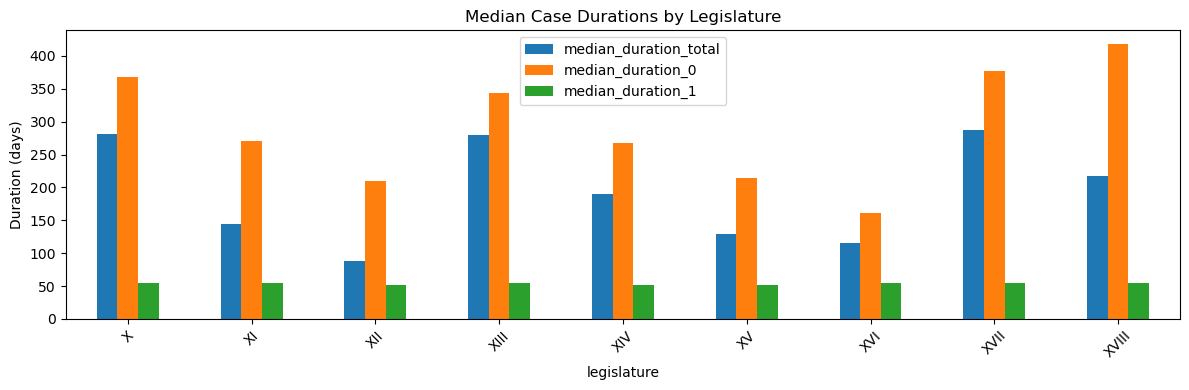

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
summary.set_index('legislature')[['median_duration_total', 'median_duration_0', 'median_duration_1']].plot(
    kind='bar', ax=ax
)
ax.set_title('Median Case Durations by Legislature')
ax.set_ylabel('Duration (days)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()